<a href="https://colab.research.google.com/github/pglez82/IFCB_semisupervised/blob/master/IFCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showing system info

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Sun Jun 21 11:50:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:17:00.0 Off |                  N/A |
| 31%   53C    P0    75W / 250W |     10MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            Off  | 00000000:65:00.0 Off |                  N/A |
| 23%   35C    P8     9W / 250W |     10MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# Download SimCLR code
In this step we download the SimCLR code for **PyTorch** and install its dependencies



In [2]:
import os

if not os.path.isdir("SimCLR"):
  !git clone https://github.com/pglez82/SimCLR.git
 
%cd SimCLR
!sh setup.sh || python3 -m pip install -r requirements.txt || exit 1
!pip install  pyyaml --upgrade

/media/HDD/pgonzalez/IFCB_semisupervised/SimCLR

CondaValueError: prefix already exists: /home/pgonzalez/anaconda3/envs/simclr

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda


Ran pip subprocess with arguments:
['/home/pgonzalez/anaconda3/envs/simclr/bin/python', '-m', 'pip', 'install', '-U', '-r', '/media/HDD/pgonzalez/IFCB_semisupervised/SimCLR/condaenv.7rolojbs.requirements.txt']
Pip subprocess output:
Requirement already up-to-date: sacred in /home/pgonzalez/anaconda3/envs/simclr/lib/python3.8/site-packages (from -r /media/HDD/pgonzalez/IFCB_semisupervised/SimCLR/condaenv.7rolojbs.requirements.txt (line 1)) (0.8.1)

#
# To activate this environment, use
#
#     $ conda activate simclr
#
# To deactivate an active environment, use
#
#     $ conda deactivate

Processing /home/pgonzalez/.cache/pip/wheels/5e/03/1e/e1e954795d6f35df

# Download the images
In this section, we **donwload** the data and **uncompress** it. The code has checks in order to ensure that already downloaded data is not redownloaded

In [3]:
%cd ..
if not os.path.isfile("IFCB_data.tar") and not os.path.isdir("data"):
  print("Data do not exist in local. Downloading...")
  !wget -O IFCB_data.tar https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/Ec2z0uC4lghEg-9MjzoJ9QkBK5n74QjS-LszB9dlNrPfaw?download=1
else:
  print("Data already exists. Skipping download.")

if not os.path.isdir("data"):
  print("Extracting the tar file...")
  !tar -xf "IFCB_data.tar"
  print("Done. Removing the tar file.")
  !rm -f IFCB_data.tar #Remove the original file to save space

/media/HDD/pgonzalez/IFCB_semisupervised
Data already exists. Skipping download.


# Download CSV with information about the images


In [4]:
import pandas as pd

if not os.path.isfile('IFCB.csv.zip'):
  print("CSV data do not exist. Downloading...")
  !wget -O IFCB.csv.zip "https://unioviedo-my.sharepoint.com/:u:/g/personal/gonzalezgpablo_uniovi_es/EfsVLhFsYJpPjO0KZlpWUq0BU6LaqJ989Re4XzatS9aG4Q?download=1"

data = pd.read_csv('IFCB.csv.zip',compression='infer', header=0,sep=',',quotechar='"')
print(data)

                        Sample  roi_number        OriginalClass  \
0        IFCB1_2006_158_000036           1                  mix   
1        IFCB1_2006_158_000036           2  Tontonia_gracillima   
2        IFCB1_2006_158_000036           3                  mix   
3        IFCB1_2006_158_000036           4                  mix   
4        IFCB1_2006_158_000036           5                  mix   
...                        ...         ...                  ...   
3457814  IFCB5_2014_353_205141        6850       Leptocylindrus   
3457815  IFCB5_2014_353_205141        6852                  mix   
3457816  IFCB5_2014_353_205141        6855                  mix   
3457817  IFCB5_2014_353_205141        6856                  mix   
3457818  IFCB5_2014_353_205141        6857                  mix   

              AutoClass FunctionalGroup  
0                   mix      Flagellate  
1           ciliate_mix         Ciliate  
2                   mix      Flagellate  
3                   mix    

# Create training set

Here we make a reestructuration of the images depending on which class we consider

In [5]:
import progressbar
from tqdm import tqdm
from shutil import copyfile

tqdm.pandas()

classcolumn = "AutoClass" #Autoclass means 51 classes
#nclasses = 51 #Pick this number of most abundant classes to make sure that we do not have empty classes
yearstraining = ['2013'] #Years to consider as training
yearsvalidation = ['2014']
trainingfolder = "training"
validationfolder = "validation"

#In order to ensure that all tests have same number of classes, 
#classes=list(pd.crosstab(index=data[classcolumn],columns='count').sort_values('count',ascending=False)[0:nclasses].index)
#print("Considering %i classes" % len(classes))
#print(classes)

print("Computing image paths...")
#Compute data paths
data['year'] = data['Sample'].str[6:10].astype(str)
data['path']="data"+'/'+data['year']+'/'+data['OriginalClass'].astype(str)+'/'+data['Sample'].astype(str)+'_'+data['roi_number'].apply(lambda x: str(x).zfill(5))+'.png'
print('Done')

#data[classcolumn][~data[classcolumn].isin(classes)]='mix' #Put ignored classes into mix category

#Check data by year
print(pd.crosstab(index=data['year'],columns='count'))

if not os.path.isdir(trainingfolder):
  print("Create folder structure for training set... Using years:")
  print(yearstraining)
  os.mkdir(trainingfolder)
  for folder in classes:
    os.mkdir(os.path.join(trainingfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearstraining)].progress_apply(lambda row: copyfile(row['path'],os.path.join(trainingfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")
else:
  print("Training data already there... Doing nothing")

if not os.path.isdir(validationfolder):
  print("Create folder structure for the validation set... Using years:")
  print(yearsvalidation)
  os.mkdir(validationfolder)
  for folder in classes:
    os.mkdir(os.path.join(validationfolder,folder))
  print("Done.\nMoving images to the respective folders...")
  data[data['year'].isin(yearsvalidation)].progress_apply(lambda row: copyfile(row['path'],os.path.join(validationfolder,row[classcolumn],os.path.basename(row['path']))),axis=1)
  print("Done")  
else:
  print("Validation data already there... Doing nothing")

Computing image paths...


/home/pgonzalez/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Done
col_0   count
year         
2006   131002
2007   273080
2008   427308
2009   732398
2010   327996
2011   419692
2012   394766
2013   422255
2014   329322
Training data already there... Doing nothing
Validation data already there... Doing nothing


# Lets configure SimCLR
Number of epocs, optimizer, resnet version to use ...
Things that we have to configure:


*   cuda:0 -> Change to cuda:1 to use second gpu
*   args.batch_size -> higher value its slower but better
*   args.resnet -> resnet18 | resnet50



In [6]:
import torch
from SimCLR.utils.yaml_config_hook import yaml_config_hook
import argparse
import random

torch.manual_seed(0) #Reproducible
random.seed(0) #it seems that the transforms uses this random

config = yaml_config_hook("./SimCLR/config/config.yaml")
args = argparse.Namespace(**config)

#Here we need to select which graphics card we want to use in case of having more than one
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using %s" % args.device)

Using cuda:0


In [7]:
from pprint import pprint
args.dataset = "IFCB" #This value will be used only for the output dir
args.image_size = 224 #@param
args.batch_size =  256 #@param
args.resnet = "resnet18" #@param ['resnet18','resnet50']
#Means that we want to start training in this epoch. We should have a file checkpoint_{}.tar in the args.model_path dir
args.epoch_num =  100 #@param 
#How many epochs we want. If epochs = epoch num we just load the model and do nothing
args.epochs = 100 #@param  
#We want to save the checkpoints to google drive
args.out_dir = "drive/My Drive/Colab Notebooks/{}_{}_b{}_s{}".format(args.dataset,args.resnet,args.batch_size,args.image_size)
args.model_path = args.out_dir #This is the directory from where we want to restore checkpoints
args.proportions = [0.01,0.05,0.08,0.09,0.1,0.15,0.2,0.3,0.4,0.5,0.8,1] #how many labeled data we are going to use for training
args.logistic_epochs = 500
args.workers = 4

if not os.path.isdir(args.out_dir):
  raise SystemExit("The output folder {} does not exist!".format(args.out_dir))
pprint(vars(args))

{'batch_size': 256,
 'dataset': 'IFCB',
 'device': device(type='cuda', index=0),
 'epoch_num': 100,
 'epochs': 100,
 'fp16': False,
 'fp16_opt_level': 'O2',
 'image_size': 224,
 'logistic_batch_size': 256,
 'logistic_epochs': 500,
 'model_path': 'drive/My Drive/Colab Notebooks/IFCB_resnet18_b256_s224',
 'normalize': True,
 'optimizer': 'Adam',
 'out_dir': 'drive/My Drive/Colab Notebooks/IFCB_resnet18_b256_s224',
 'pretrain': True,
 'projection_dim': 64,
 'proportions': [0.01, 0.05, 0.08, 0.09, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.8, 1],
 'resnet': 'resnet18',
 'seed': 42,
 'start_epoch': 0,
 'temperature': 0.5,
 'weight_decay': 1e-06,
 'workers': 4}


# Loading the training dataset

Use pytorch to load the training dataset

In [8]:
import torchvision
from torchvision import transforms
from SimCLR.modules.transformations import TransformsSimCLR

#This transform makes the magic and returns two augmented images from an original image
train_dataset = torchvision.datasets.ImageFolder(root=trainingfolder, transform=TransformsSimCLR(size=args.image_size))

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=args.batch_size,
  shuffle=False,
  drop_last=True,
  num_workers=args.workers,
)

# Show some example pictures

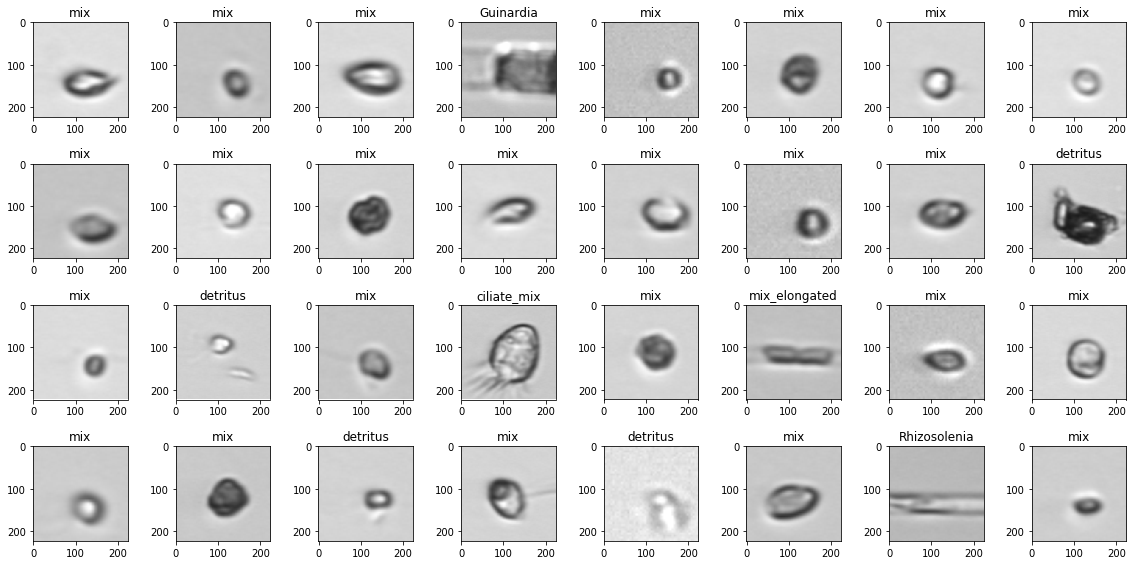

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

train_dataset_display = torchvision.datasets.ImageFolder(root=trainingfolder,
                                                         transform=T.Compose([T.Resize(size=args.image_size),
                                                                              T.CenterCrop(size=args.image_size)]))
fig, axs = plt.subplots(nrows=4, ncols=8, constrained_layout=False, figsize=(16,8))
fig.tight_layout()
for _, ax in enumerate(axs.flat):
  index = random.randint(0, len(train_dataset_display)-1)
  ax.imshow(train_dataset_display[index][0])
  ax.title.set_text(train_dataset_display.classes[train_dataset_display[index][1]])
plt.show()

# Define the training function
This is the function that will do all the work for one epoch

In [10]:
import time

def train(args, train_loader, model, criterion, optimizer, writer):
  loss_epoch = 0
  start_time = time.time()
  for step, ((x_i, x_j), _) in enumerate(train_loader):
    optimizer.zero_grad()
    x_i = x_i.to(args.device)
    x_j = x_j.to(args.device)

    # positive pair, with encoding
    h_i, z_i = model(x_i)
    h_j, z_j = model(x_j)

    loss = criterion(z_i, z_j)

    loss.backward()

    optimizer.step()

    if step % 50 == 0:
      spent = time.time()-start_time
      print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()} \t Time: {spent} secs [{(args.batch_size*50)/spent} ej/sec]]")
      start_time = time.time()

    writer.add_scalar("Loss/Step", loss.item(), args.global_step)
    loss_epoch += loss.item()
    args.global_step += 1

  return loss_epoch

# Load the model
We only reload the model if **args.epoch_num** is different from zero. This case means that we want to continue training from a checkpoint (we should have the model in the **args.model_path** dir.

In [11]:
from SimCLR.model import load_model
model, optimizer, scheduler = load_model(args, train_loader,reload_model=(args.epoch_num!=0))

# Configure TensorBoard



In [12]:
from torch.utils.tensorboard import SummaryWriter

tb_dir = os.path.join(args.out_dir, "colab")
if not os.path.exists(tb_dir):
  os.makedirs(tb_dir)
writer = SummaryWriter(log_dir=tb_dir)

# Load the loss function
This function tries to minimize the difference between the two augmented variations of the image and maximize the difference between these and the rest of the batch

In [13]:
from SimCLR.modules import NT_Xent

criterion = NT_Xent(args.batch_size, args.temperature, args.device)

# Training the CNN
We make a checkpoint each 5 epochs just in case

In [14]:
from SimCLR.model import save_model

args.global_step = 0
if args.epoch_num!=0: #If we have loaded a model trained til an epoch, lets start training in the next
  args.start_epoch=args.epoch_num+1
args.current_epoch = args.start_epoch #Variable for controlling in which epoch we are

for epoch in range(args.start_epoch, args.epochs):
  lr = optimizer.param_groups[0]['lr']
  loss_epoch = train(args, train_loader, model, criterion, optimizer, writer)

  if scheduler:
    scheduler.step()

  if epoch % 5 == 0:
    save_model(args, model, optimizer)

  writer.add_scalar("Loss/train epoch", loss_epoch / len(train_loader), epoch)
  writer.add_scalar("Misc/learning_rate", lr, epoch)
  print(f"Epoch [{epoch+1}/{args.epochs}]\t Loss: {loss_epoch / len(train_loader)}\t lr: {round(lr, 5)}")
  args.current_epoch += 1

## end training
if args.start_epoch!=args.epochs:
  save_model(args, model, optimizer)

In [15]:
#!tensorboard dev upload --logdir "$tb_dir" --name "IFCBv3" --description "Training with 2006 image size 128 batch size 256"

# **Trainining the classifier using the deep features**
Now we will be trying to find out if the network has learnt something useful from the unlabeled data. We will train a Logistic Regression classifier with the labeled examples and testing against a validation dataset

# Define train and test functions

In [16]:
def train(args, loader, model, criterion, optimizer):
  loss_epoch = 0
  accuracy_epoch = 0
  for step, (x, y) in enumerate(loader):
    optimizer.zero_grad()

    x = x.to(args.device)
    y = y.to(args.device)

    output = model(x)
    loss = criterion(output, y)

    predicted = output.argmax(1)
    acc = (predicted == y).sum().item() / y.size(0)
    accuracy_epoch += acc

    loss.backward()
    optimizer.step()

    loss_epoch += loss.item()

  return loss_epoch, accuracy_epoch

In [17]:
def make_preds(args, model, loader):
  """
  Check the accuracy of the model.
  """
  # Set the model to eval mode
  model.eval()
  y_true = []
  y_pred = []
  for x, y in loader:
    x = x.to(args.device)
    y = y.to(args.device)
    # Run the model forward, and compare the argmax score with the ground-truth
    # category.
    output = model(x)
    predicted = output.argmax(1)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
  return y_true,y_pred

# Load data
We have to load the data again because before the data loader was doing the special agumentation for the contrastive learning. Now we only want to resize the images.




In [18]:
train_dataset = torchvision.datasets.ImageFolder(root=trainingfolder, transform=TransformsSimCLR(size=args.image_size).test_transform,)
test_dataset = torchvision.datasets.ImageFolder(root=validationfolder, transform=TransformsSimCLR(size=args.image_size).test_transform,)

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=args.logistic_batch_size,
  num_workers=args.workers,
)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=args.logistic_batch_size,
  shuffle=False,
  num_workers=args.workers,
)

In [19]:
def print_class_distribution(labels,class_to_idx):
  class_mapping = {v: k for k, v in class_to_idx.items()}
  df = pd.DataFrame(data=labels)
  df=df.replace(class_mapping)
  c=pd.crosstab(index=df[0],columns='count')
  print(c)


labels_train = list(train_dataset.targets)
labels_test = list(test_dataset.targets)
print("Printing distribution of training set...")
print_class_distribution(labels_train,train_dataset.class_to_idx)
print("Printing distribution of testing set...")
print_class_distribution(labels_test,test_dataset.class_to_idx)


Printing distribution of training set...
col_0                 count
0                          
Asterionellopsis        532
Cerataulina            4136
Ceratium                 15
Chaetoceros            8765
Corethron               694
Coscinodiscus            58
Cylindrotheca          3244
DactFragCerataul       1209
Dactyliosolen           647
Dictyocha               102
Dinobryon               409
Dinophysis               12
Ditylum                 116
Ephemera                 15
Eucampia                 32
Euglena                 101
Guinardia              3180
Guinardia_flaccida       48
Guinardia_striata       149
Gyrodinium              369
Laboea                   13
Lauderia                  5
Leptocylindrus        11505
Licmophora               11
Myrionecta              266
Odontella                 5
Paralia                  29
Phaeocystis              10
Pleurosigma              45
Prorocentrum            538
Pseudonitzschia         242
Pyramimonas             121
Rhizoso

# Load de pretrained CNN and its weights

In [20]:
simclr_model, _, _ = load_model(args, train_loader, reload_model=True)
simclr_model = simclr_model.to(args.device)
simclr_model.eval()

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Compute deep features for both training and validation sets
Here we use our CNN pretrained using contrastive learning with unlabelled data for computing the features from all the examples.

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_balanced_splits(y,proportions):
  """
  This function creates different balanced splits following the proportions
  """
  classes, globalcounts = np.unique(y, return_counts=True) #If some classes do not have examples, they are not in y
  subsets = {}
  for p in proportions:
    subsets[p]=[]
    counts = np.rint(globalcounts*p)
    counts[counts==0]=1
    print("Building subset with %d elements"%sum(counts))
    for i in range(len(classes)):
      #print("For class %d we have %d examples and we are taking %d" % (classes[i],globalcounts[i],counts[i]))
      classelements, = np.where(y==classes[i])
      subsets[p].extend(classelements[0:int(counts[i])])
  return subsets 

#This function computes the deep features
def inference(loader, context_model, device):
  feature_vector = []
  labels_vector = []
  for step, (x, y) in enumerate(loader):
    x = x.to(device)

    # get encoding
    with torch.no_grad():
      h, z = context_model(x)

    h = h.detach()

    feature_vector.extend(h.cpu().detach().numpy())
    labels_vector.extend(y.numpy())

    if step % 20 == 0:
      print(f"Step [{step}/{len(loader)}]")

  feature_vector = np.array(feature_vector)
  labels_vector = np.array(labels_vector)
  print("Features shape {}".format(feature_vector.shape))
  return feature_vector, labels_vector

def get_features(context_model, train_loader, test_loader, device):
  print("Computing deep features for training set...")
  train_X, train_y = inference(train_loader, context_model, device)
  print("Computing deep features for validation set...")
  test_X, test_y = inference(test_loader, context_model, device)
  return train_X, train_y, test_X, test_y

def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size, proportions):
  #We want to create multiple train loaders with different labelled data proportions
  indexes = create_balanced_splits(y_train,args.proportions)
  train_loaders = {}
  for p in args.proportions:
    d = torch.utils.data.TensorDataset(torch.from_numpy(X_train[indexes[p]]), torch.from_numpy(y_train[indexes[p]]))
    train_loaders[p]=torch.utils.data.DataLoader(d, batch_size=batch_size, shuffle=True)
  test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
  test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
  return train_loaders, test_loader

(train_X, train_y, test_X, test_y) = get_features(simclr_model, train_loader, test_loader, args.device)
print("Done")

#We create the data loaders from the arrays with the deep features
arr_train_loaders, arr_test_loader = create_data_loaders_from_arrays(train_X, train_y, test_X, test_y, args.logistic_batch_size,args.proportions)


Computing deep features for training set...
Step [0/1650]
Step [20/1650]
Step [40/1650]
Step [60/1650]
Step [80/1650]
Step [100/1650]
Step [120/1650]
Step [140/1650]
Step [160/1650]
Step [180/1650]
Step [200/1650]
Step [220/1650]
Step [240/1650]
Step [260/1650]
Step [280/1650]
Step [300/1650]
Step [320/1650]
Step [340/1650]
Step [360/1650]
Step [380/1650]
Step [400/1650]
Step [420/1650]
Step [440/1650]
Step [460/1650]
Step [480/1650]
Step [500/1650]
Step [520/1650]
Step [540/1650]
Step [560/1650]
Step [580/1650]
Step [600/1650]
Step [620/1650]
Step [640/1650]
Step [660/1650]
Step [680/1650]
Step [700/1650]
Step [720/1650]
Step [740/1650]
Step [760/1650]
Step [780/1650]
Step [800/1650]
Step [820/1650]
Step [840/1650]
Step [860/1650]
Step [880/1650]
Step [900/1650]
Step [920/1650]
Step [940/1650]
Step [960/1650]
Step [980/1650]
Step [1000/1650]
Step [1020/1650]
Step [1040/1650]
Step [1060/1650]
Step [1080/1650]
Step [1100/1650]
Step [1120/1650]
Step [1140/1650]
Step [1160/1650]
Step [118

# Lets train the classifier and see how it works!
We are going to train the classifier using different labeled data proportions

Training dataset with proportion 0.010000 and 4352 labeled examples in training set
Epoch [0/500]	 Loss: 3.5526689641615925	 Accuracy: 0.6748121803069054
Epoch [10/500]	 Loss: 1.7101021303850061	 Accuracy: 0.7234621430093776
Epoch [20/500]	 Loss: 1.3604928325204289	 Accuracy: 0.7553315483802217
Epoch [30/500]	 Loss: 1.2411817943348604	 Accuracy: 0.7773937020460359
Epoch [40/500]	 Loss: 1.1667410275515389	 Accuracy: 0.7876005701193521
Epoch [50/500]	 Loss: 1.1090792137033798	 Accuracy: 0.7950500852514919
Epoch [60/500]	 Loss: 1.067205688532661	 Accuracy: 0.7992527173913043
Epoch [70/500]	 Loss: 1.0320034798453837	 Accuracy: 0.8048340260017051
Epoch [80/500]	 Loss: 0.9940827559022343	 Accuracy: 0.8113610933503836
Epoch [90/500]	 Loss: 0.9726390663315269	 Accuracy: 0.8135956148763853
Epoch [100/500]	 Loss: 0.9448735889266519	 Accuracy: 0.8169091005967605
Epoch [110/500]	 Loss: 0.9260943496928495	 Accuracy: 0.8202558876811594
Epoch [120/500]	 Loss: 0.9179572673404918	 Accuracy: 0.820162643

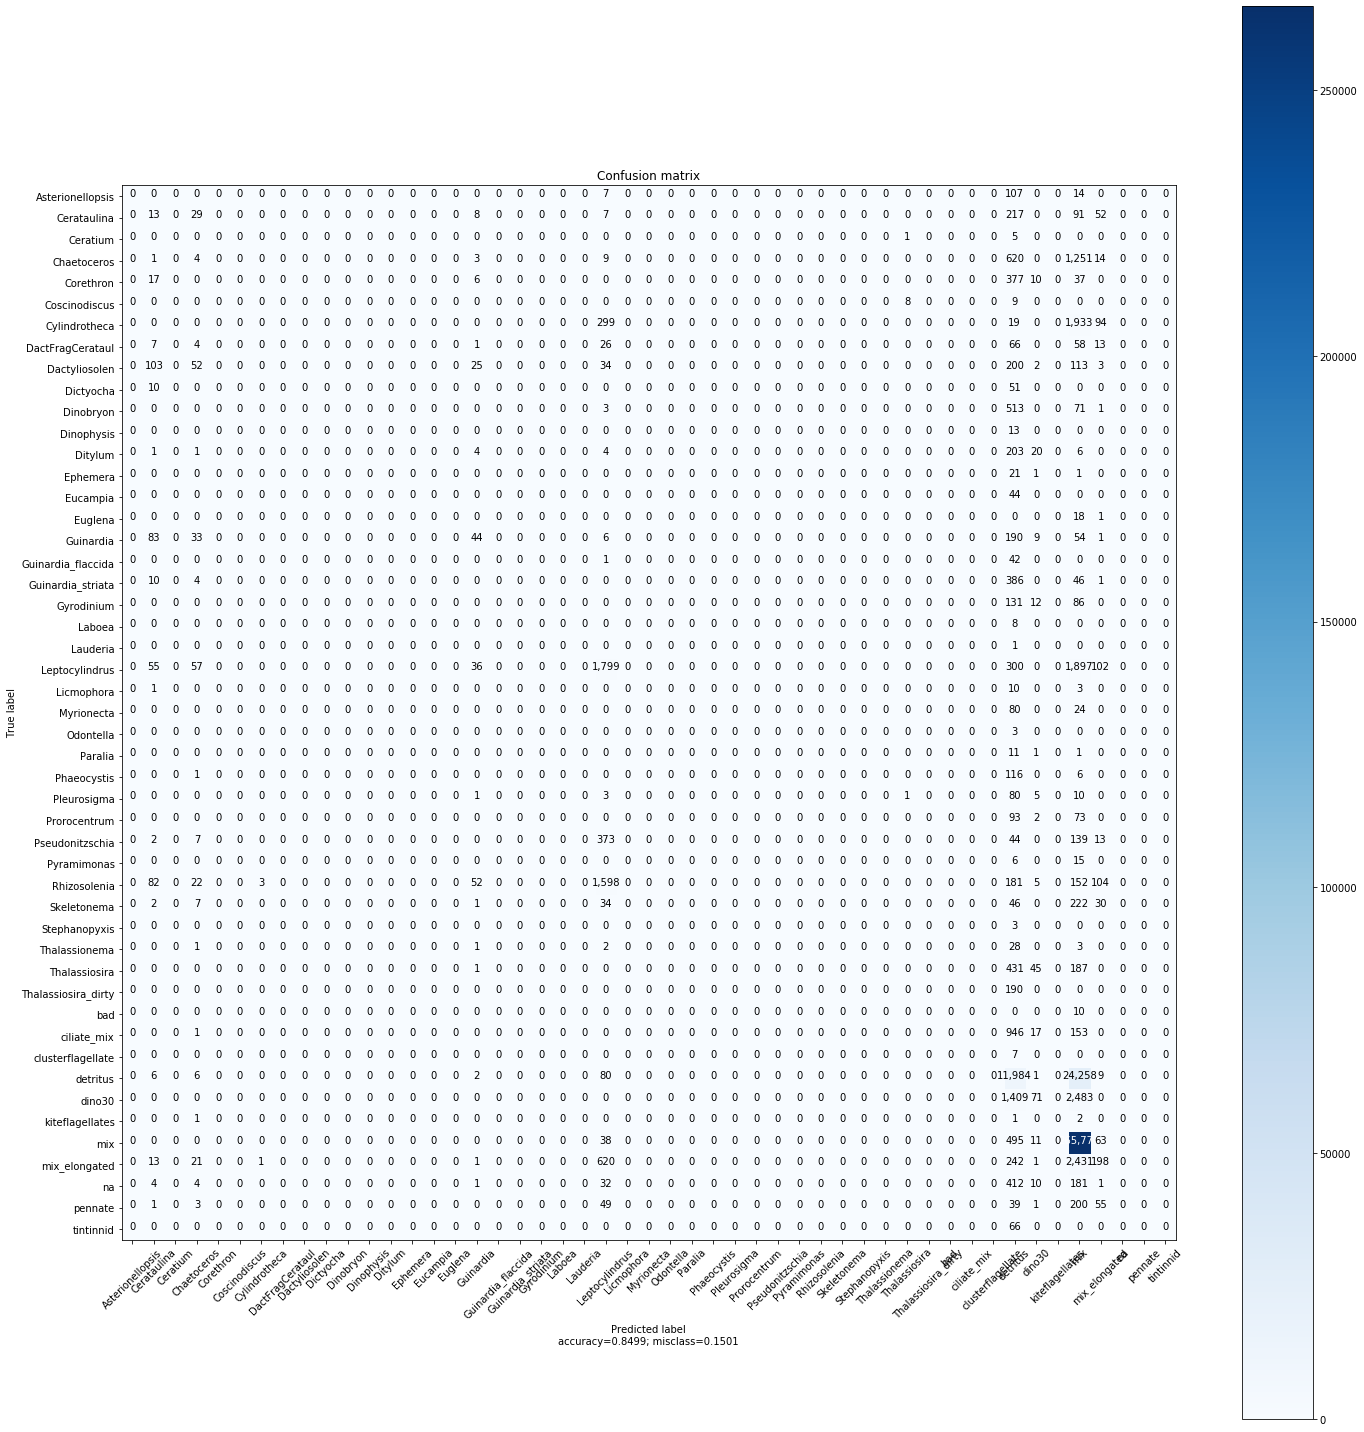

/home/pgonzalez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

   Asterionellopsis       0.00      0.00      0.00       128
        Cerataulina       0.03      0.03      0.03       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.02      0.00      0.00      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.00      0.00      0.00      2345
   DactFragCerataul       0.00      0.00      0.00       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

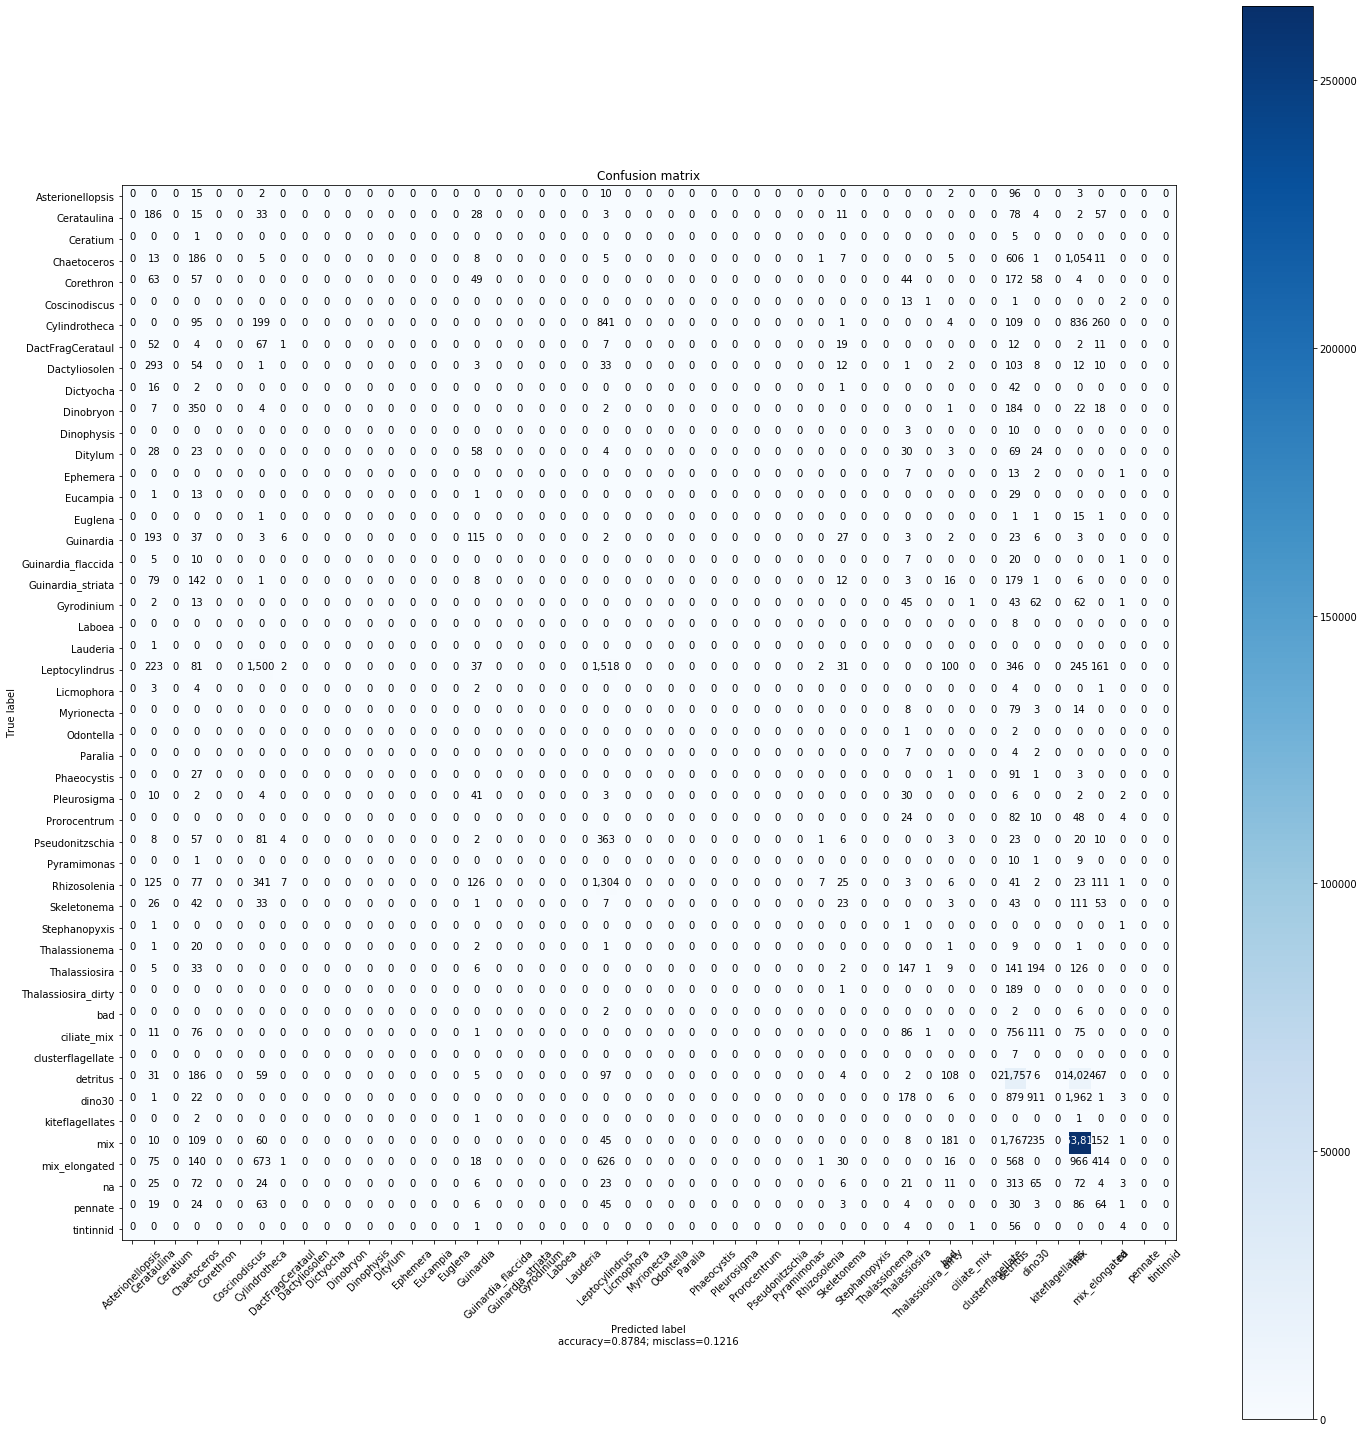

                     precision    recall  f1-score   support

   Asterionellopsis       0.00      0.00      0.00       128
        Cerataulina       0.12      0.45      0.19       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.09      0.10      0.10      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.06      0.08      0.07      2345
   DactFragCerataul       0.05      0.01      0.01       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

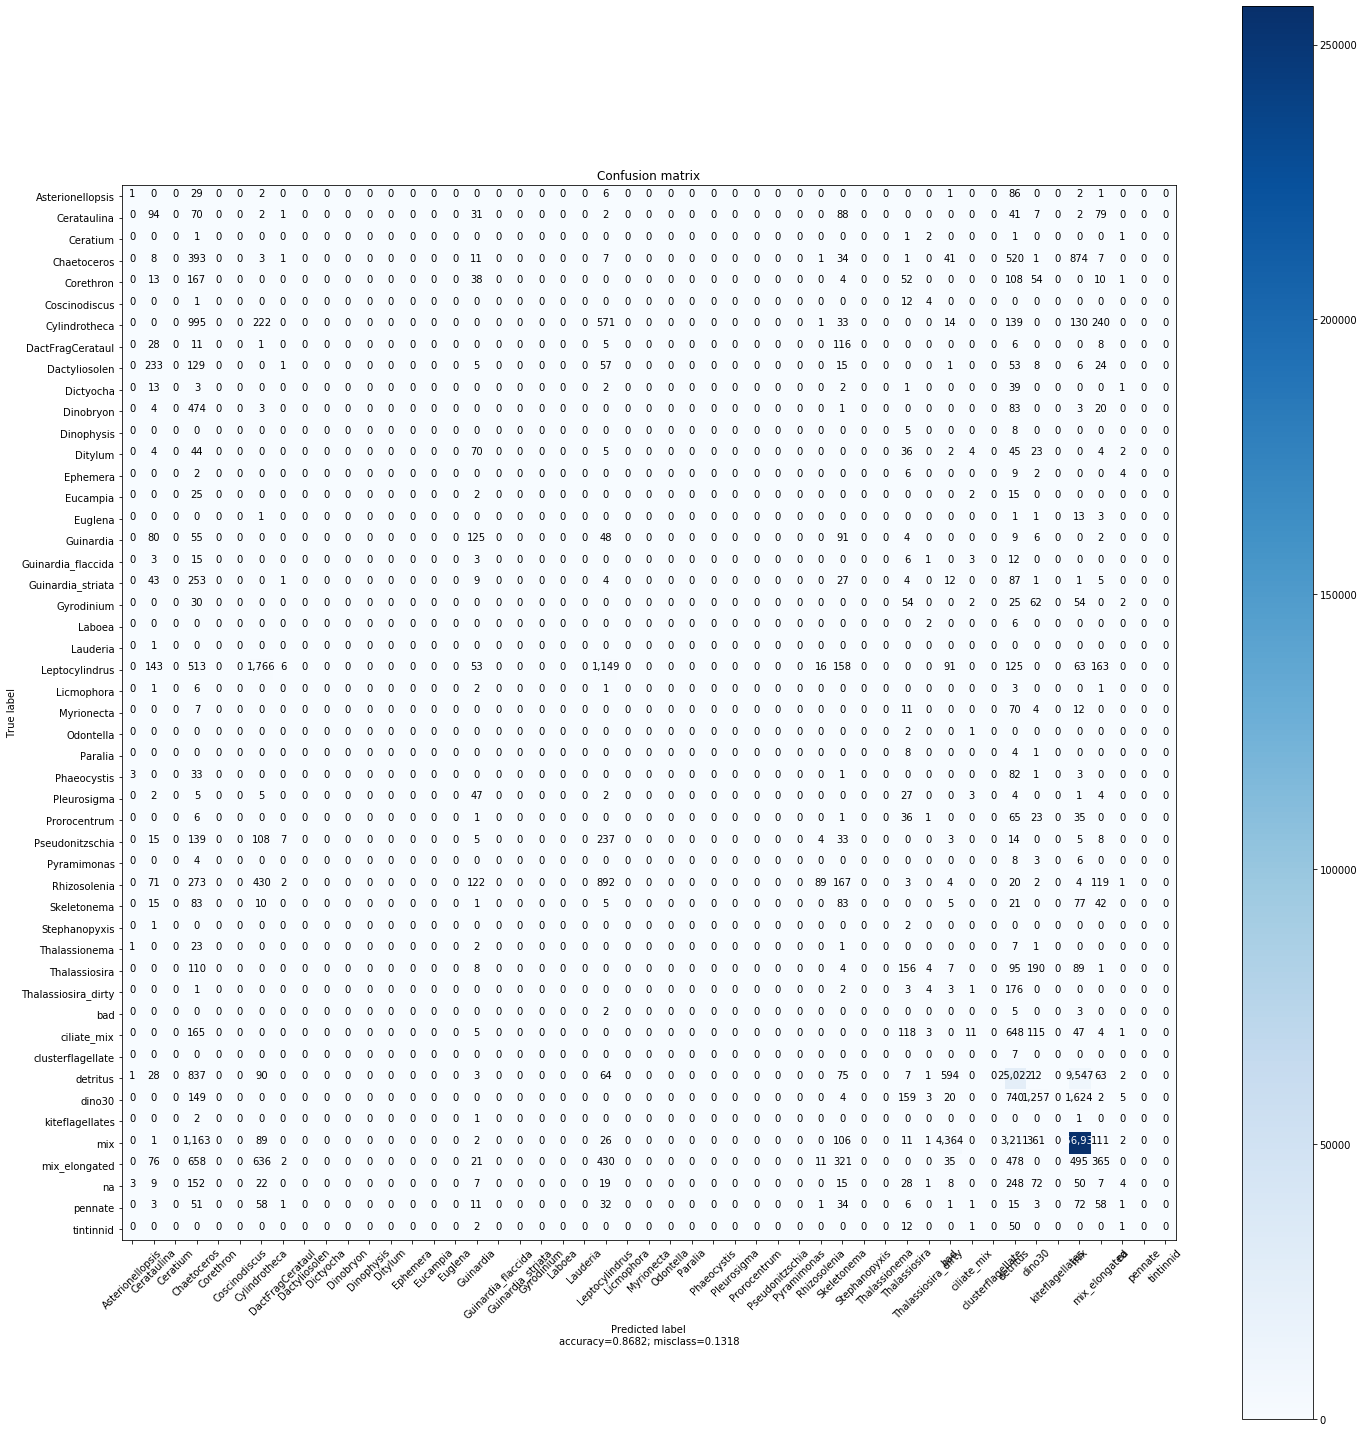

                     precision    recall  f1-score   support

   Asterionellopsis       0.11      0.01      0.01       128
        Cerataulina       0.11      0.23      0.14       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.06      0.21      0.09      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.06      0.09      0.08      2345
   DactFragCerataul       0.00      0.00      0.00       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

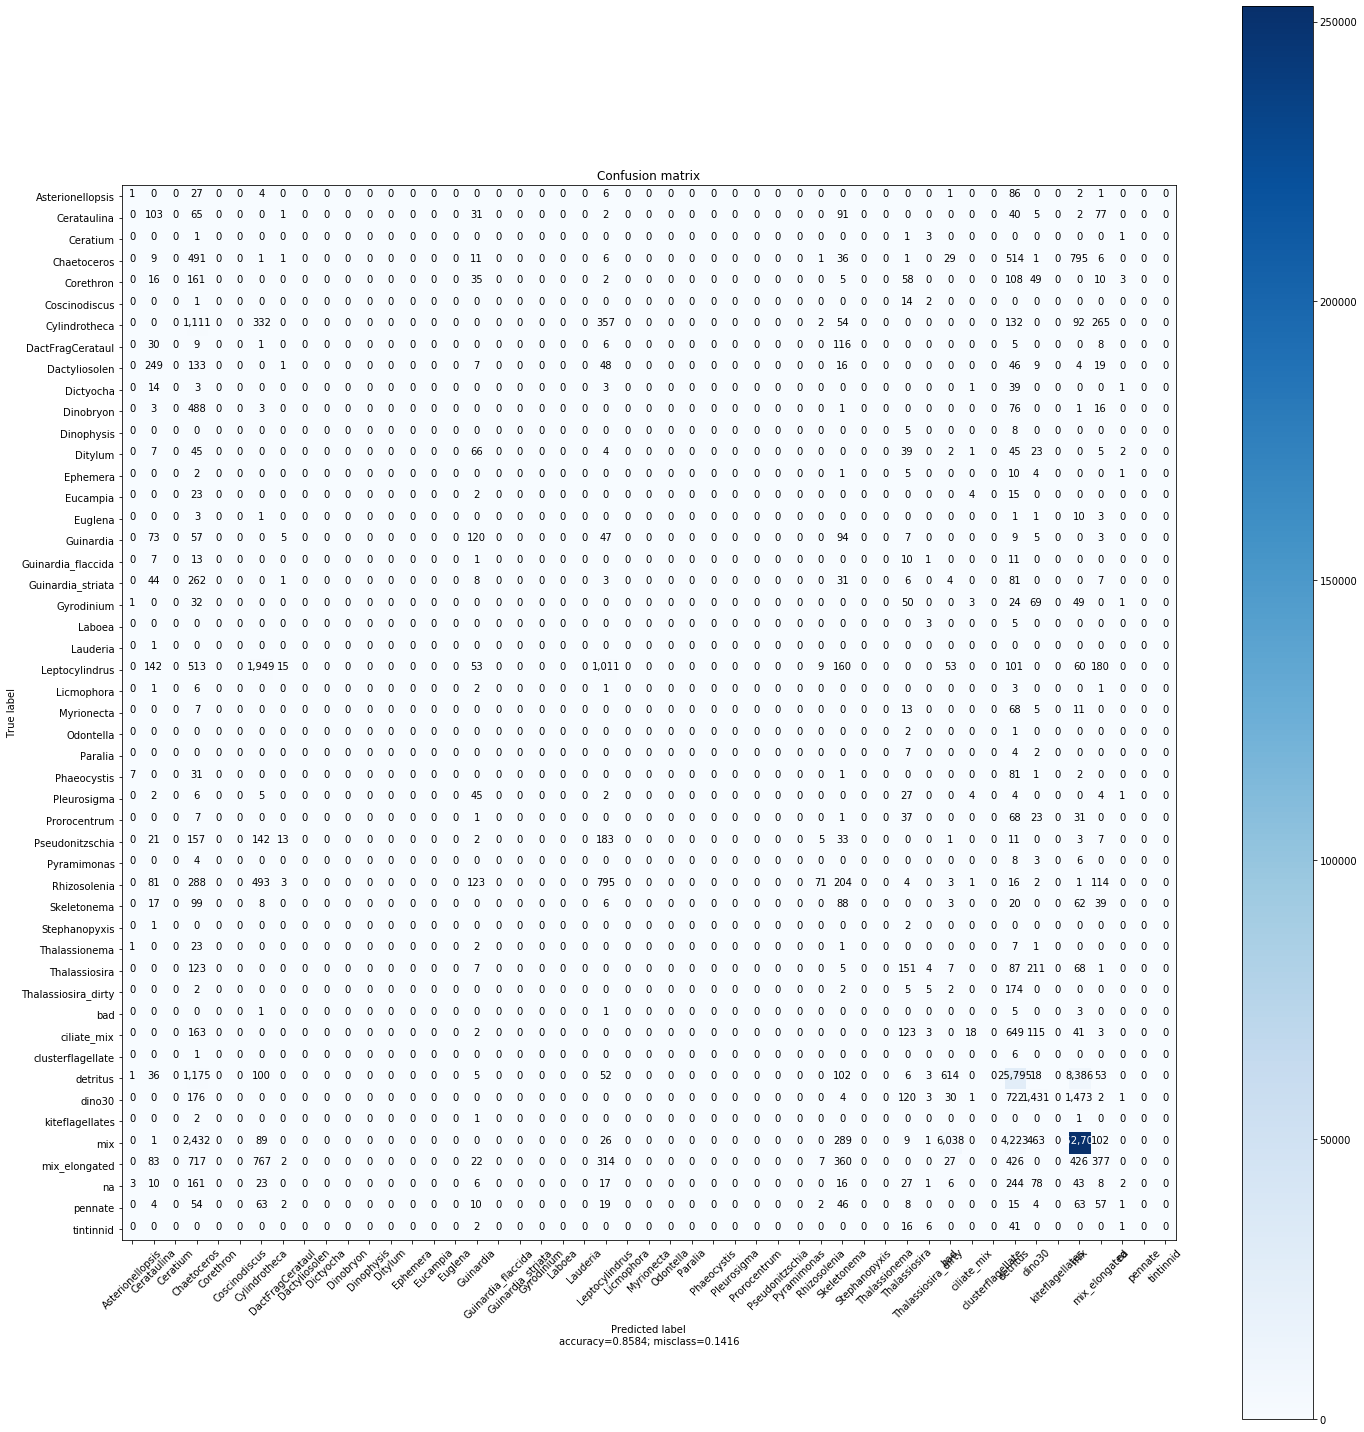

                     precision    recall  f1-score   support

   Asterionellopsis       0.07      0.01      0.01       128
        Cerataulina       0.11      0.25      0.15       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.05      0.26      0.09      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.08      0.14      0.10      2345
   DactFragCerataul       0.00      0.00      0.00       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

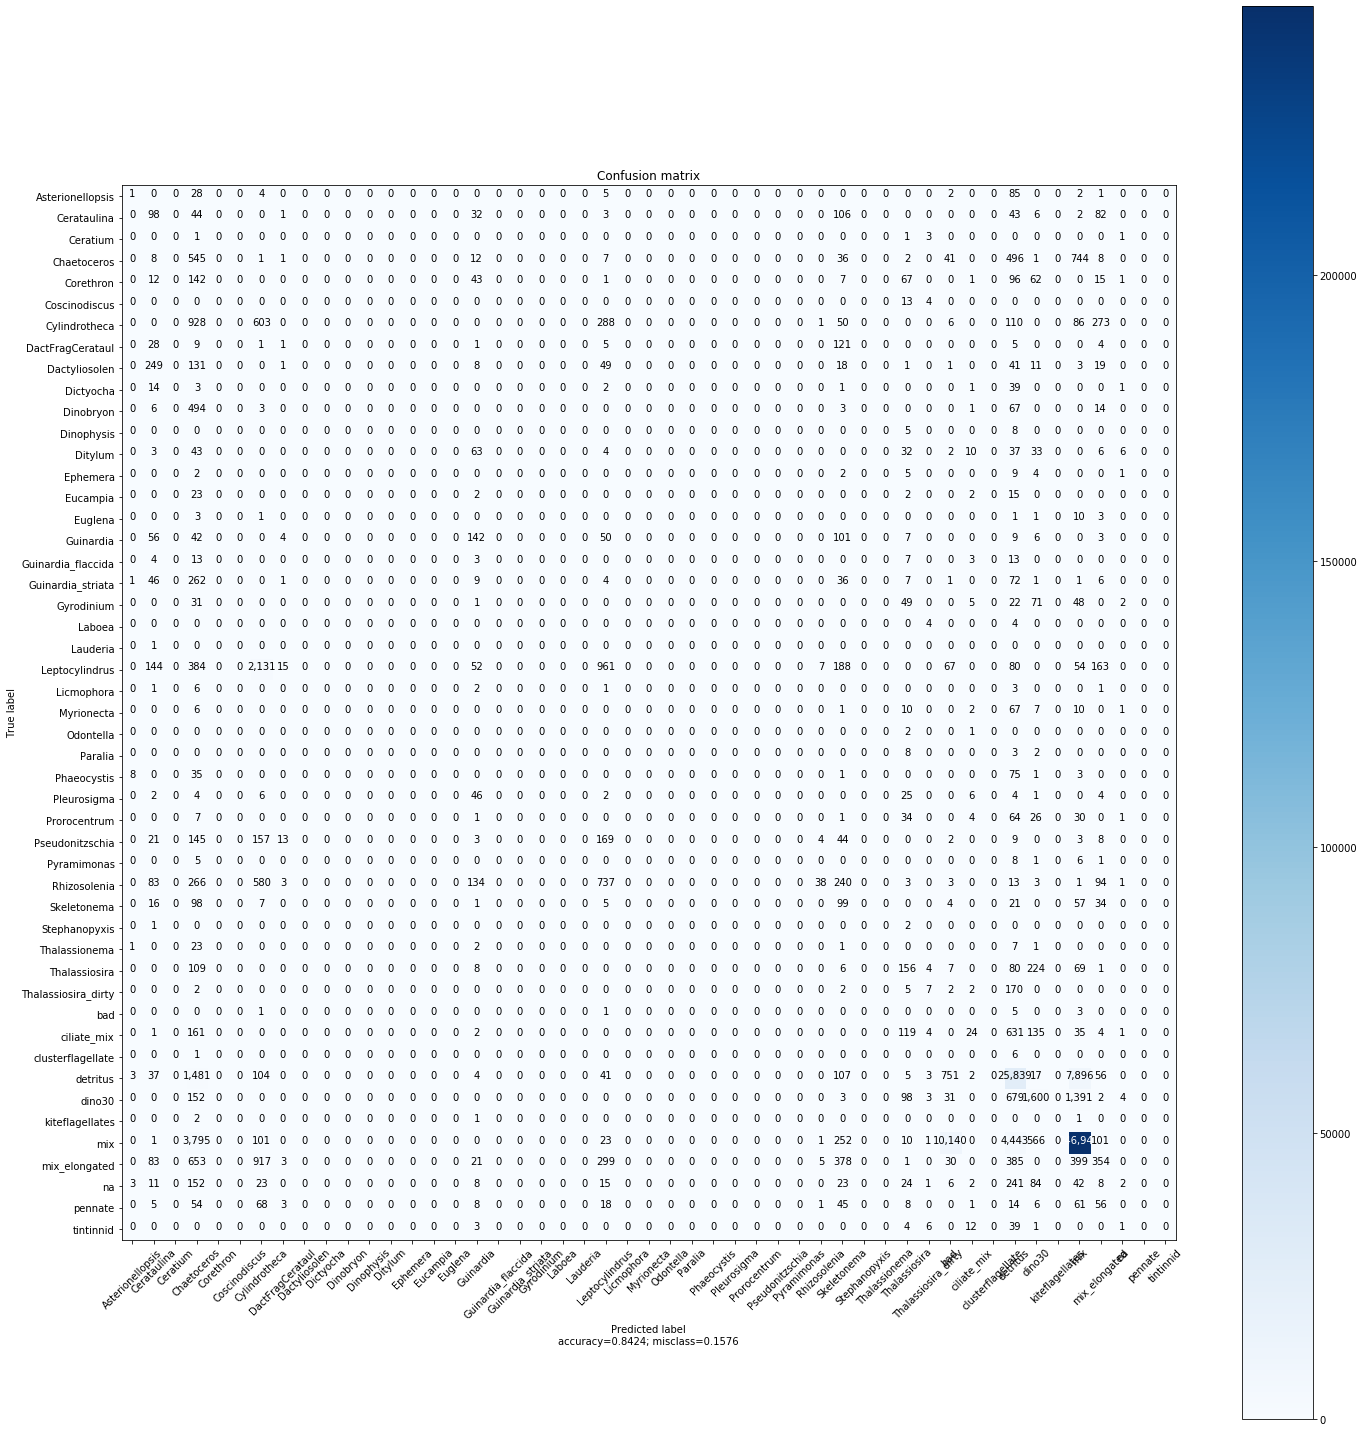

                     precision    recall  f1-score   support

   Asterionellopsis       0.06      0.01      0.01       128
        Cerataulina       0.11      0.24      0.15       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.05      0.29      0.09      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.13      0.26      0.17      2345
   DactFragCerataul       0.02      0.01      0.01       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

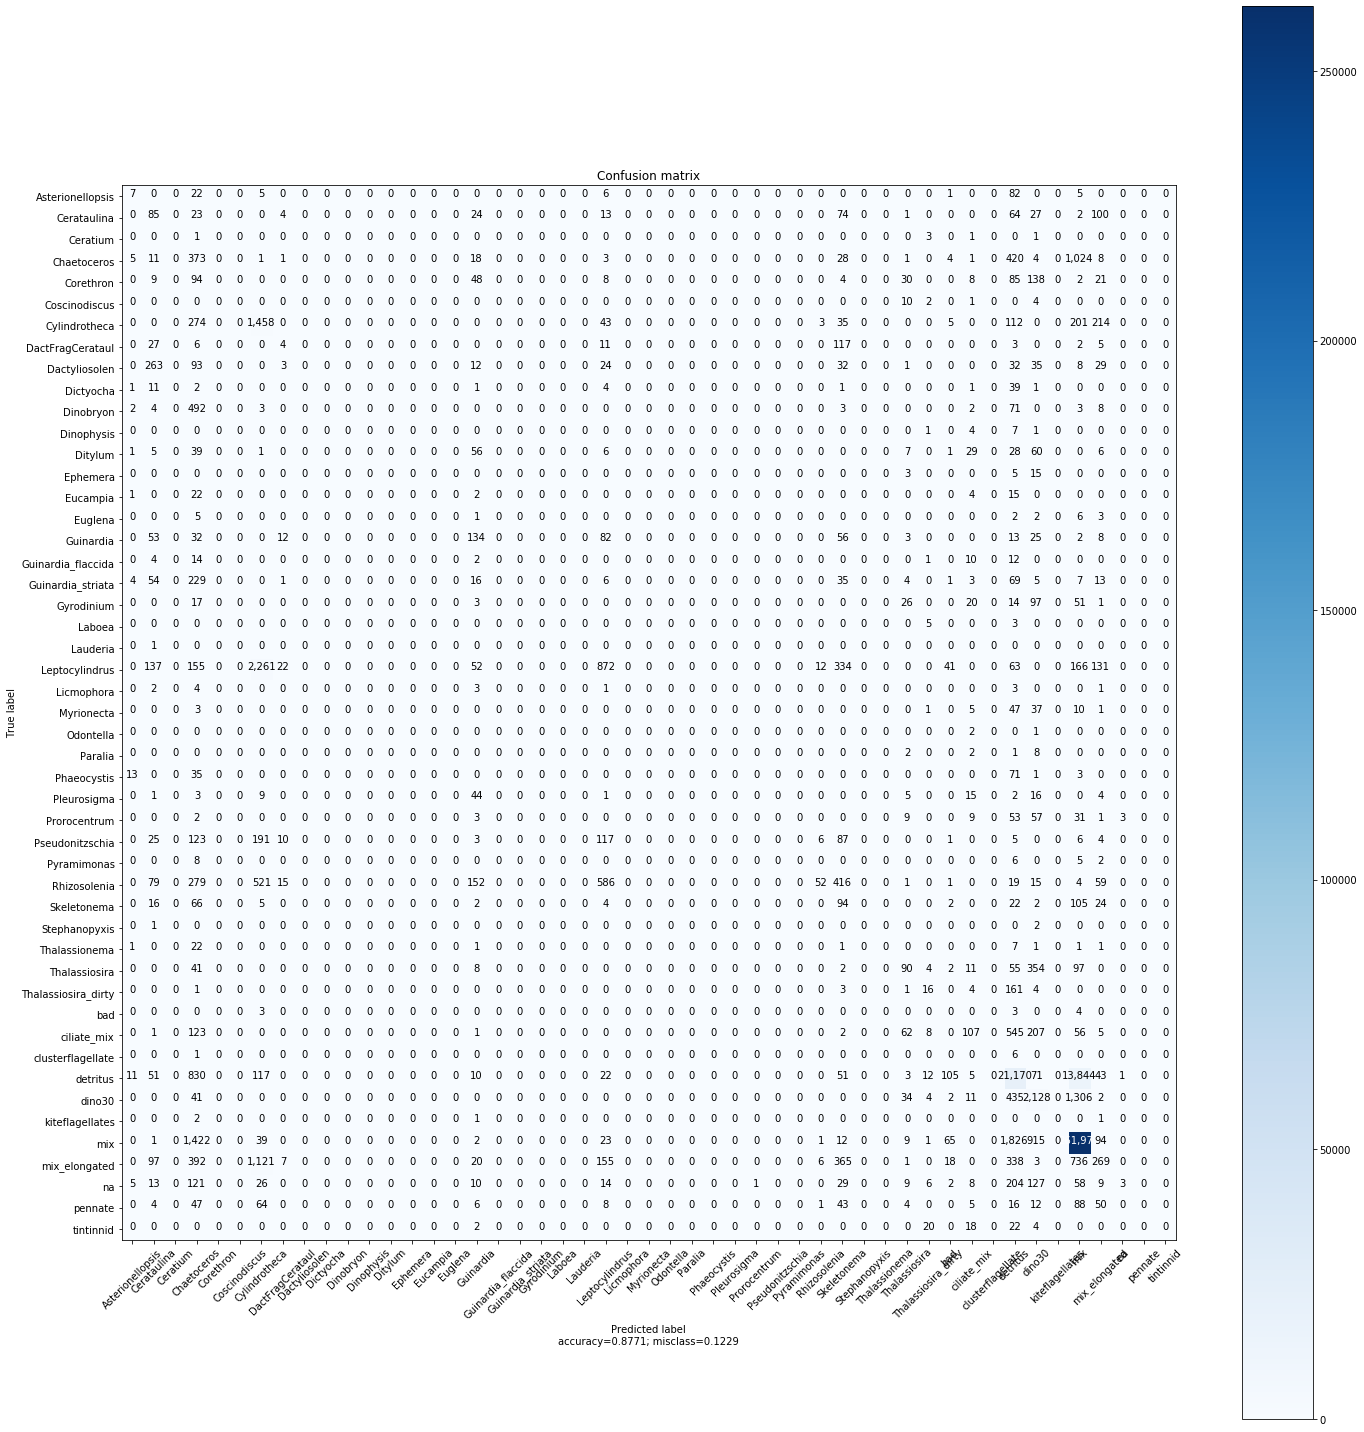

                     precision    recall  f1-score   support

   Asterionellopsis       0.14      0.05      0.08       128
        Cerataulina       0.09      0.20      0.12       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.07      0.20      0.10      1902
          Corethron       0.00      0.00      0.00       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.25      0.62      0.36      2345
   DactFragCerataul       0.05      0.02      0.03       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

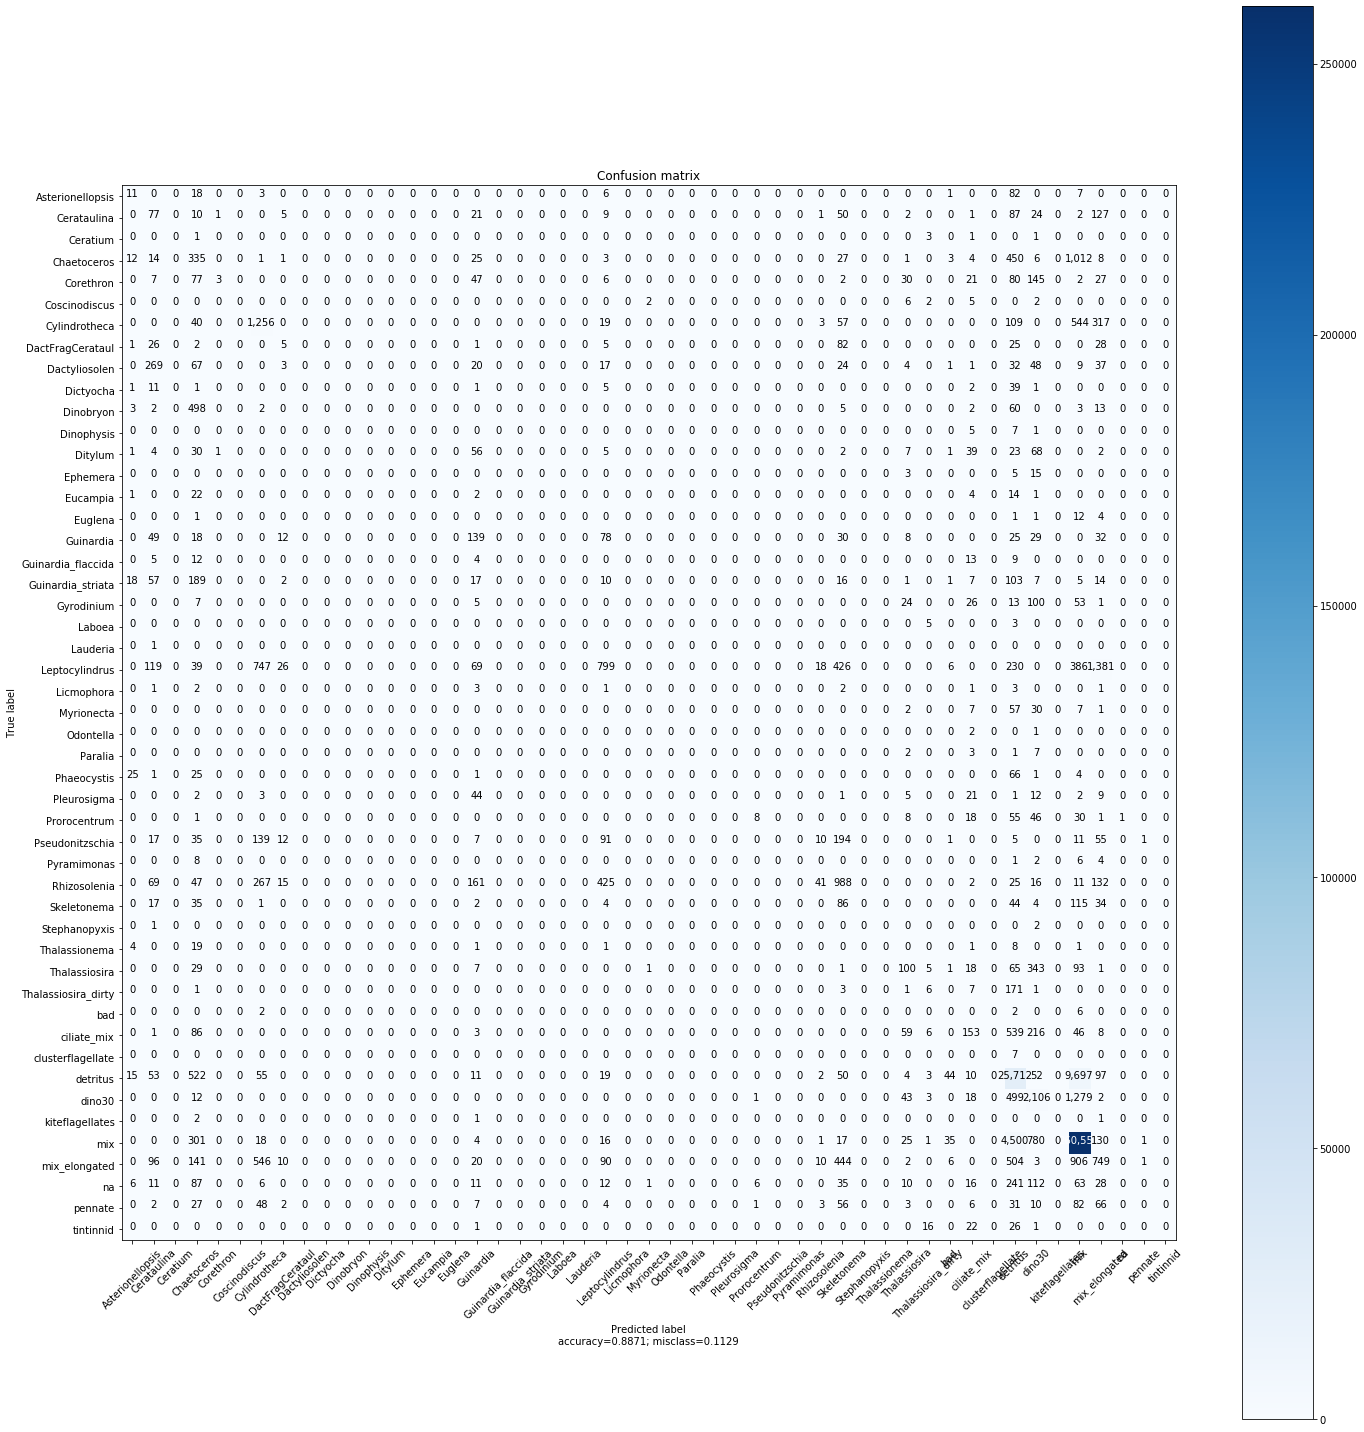

                     precision    recall  f1-score   support

   Asterionellopsis       0.11      0.09      0.10       128
        Cerataulina       0.08      0.18      0.12       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.12      0.18      0.14      1902
          Corethron       0.60      0.01      0.01       447
      Coscinodiscus       0.00      0.00      0.00        17
      Cylindrotheca       0.41      0.54      0.46      2345
   DactFragCerataul       0.05      0.03      0.04       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.00      0.00      0.00       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

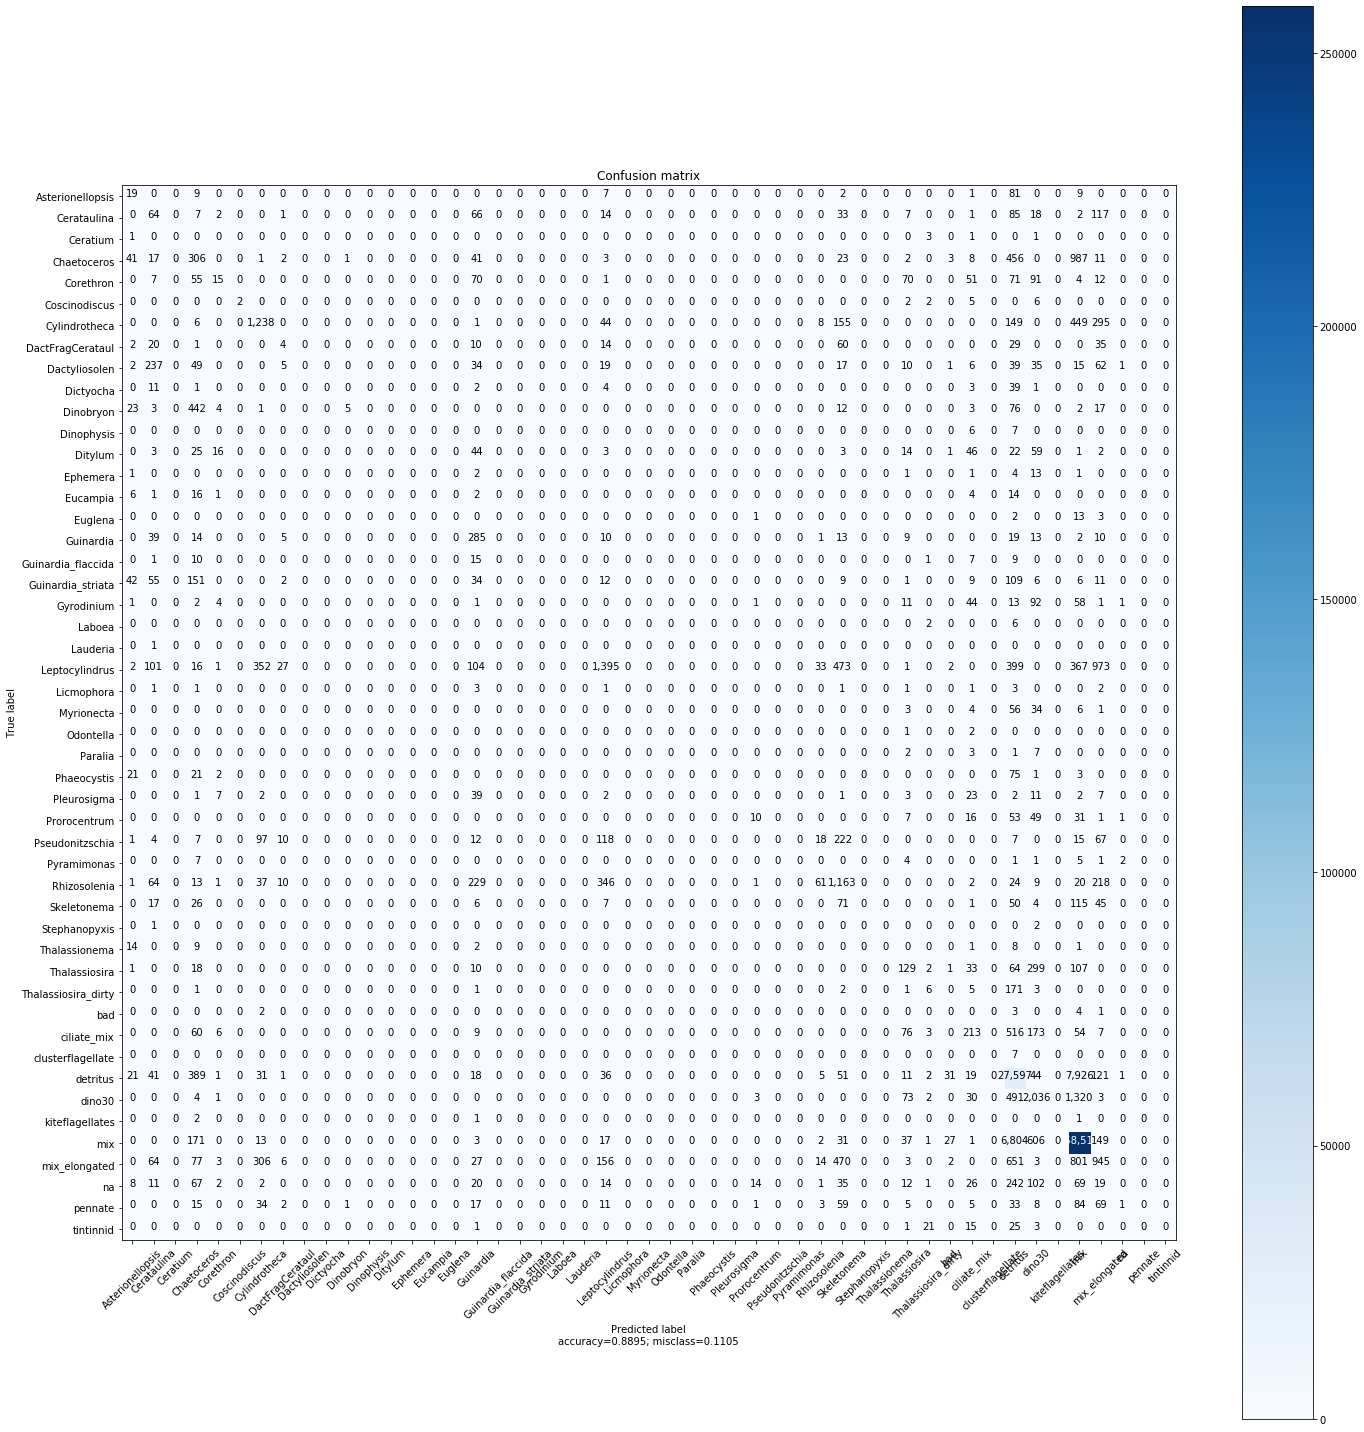

                     precision    recall  f1-score   support

   Asterionellopsis       0.09      0.15      0.11       128
        Cerataulina       0.08      0.15      0.11       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.15      0.16      0.16      1902
          Corethron       0.23      0.03      0.06       447
      Coscinodiscus       1.00      0.12      0.21        17
      Cylindrotheca       0.59      0.53      0.56      2345
   DactFragCerataul       0.05      0.02      0.03       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.71      0.01      0.02       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

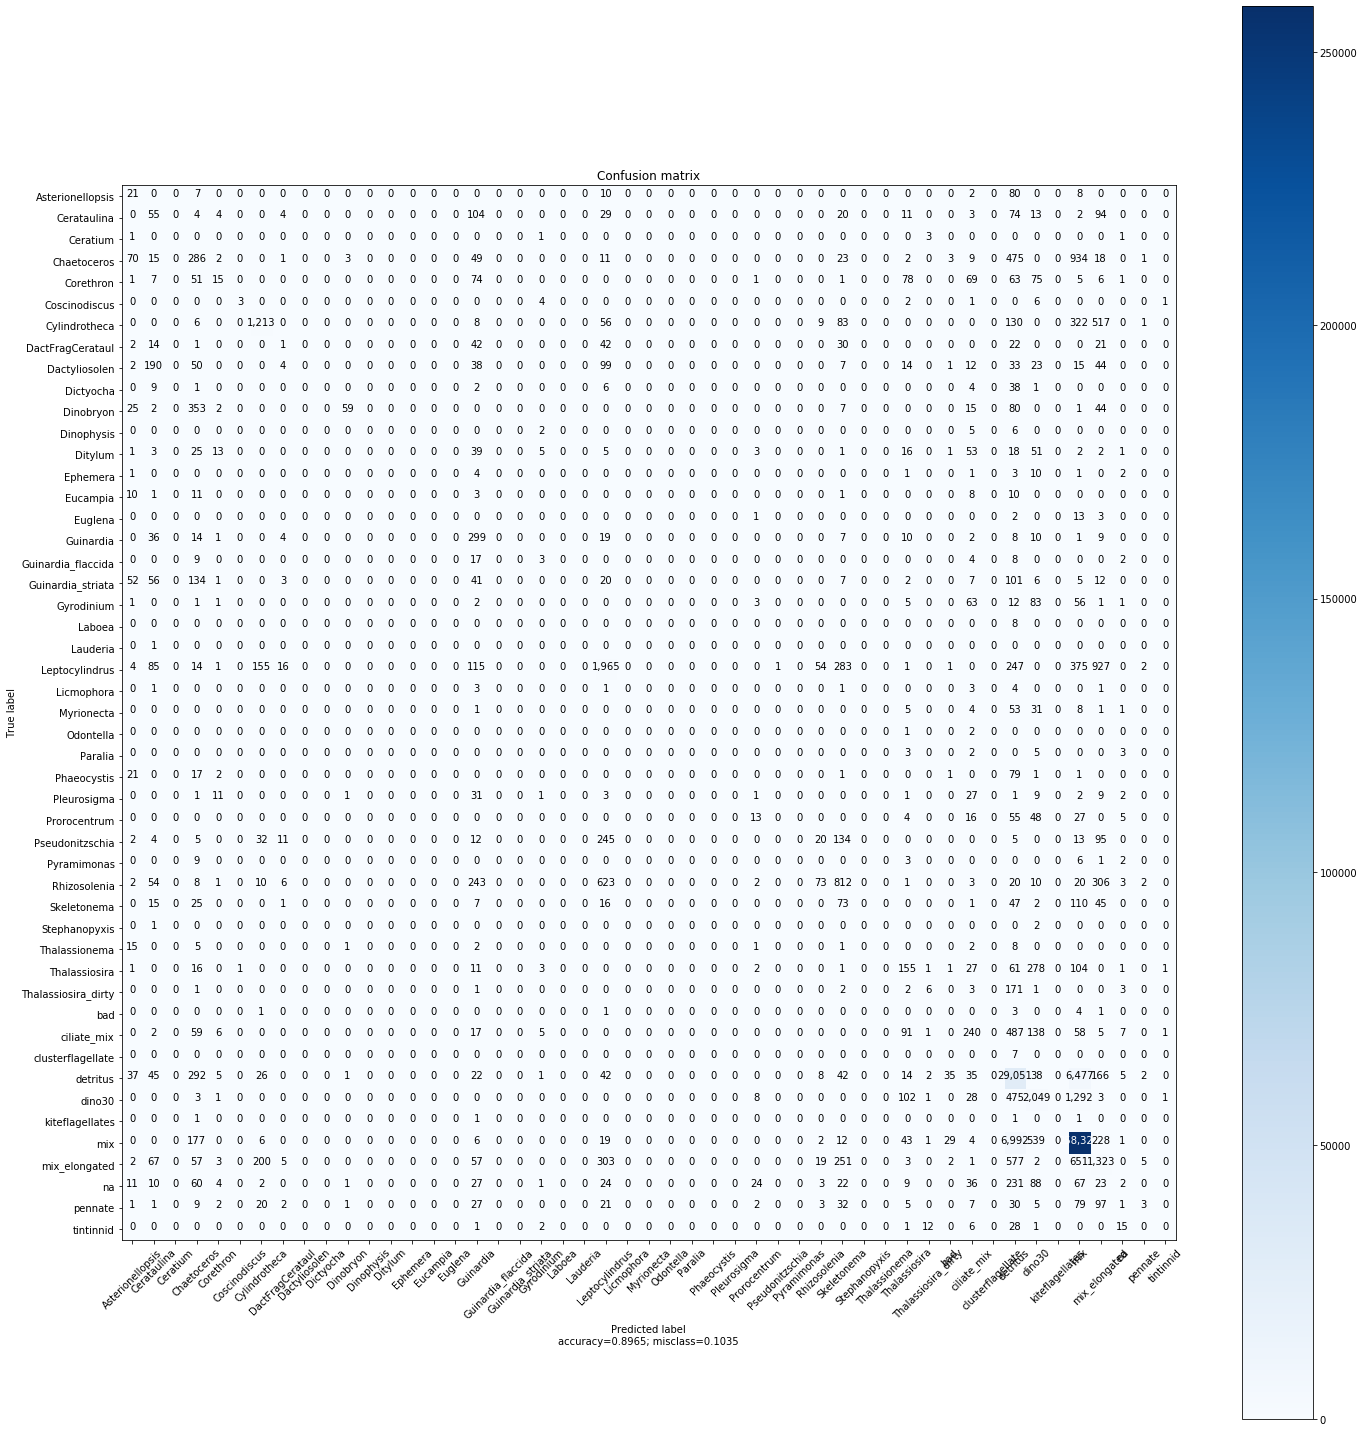

                     precision    recall  f1-score   support

   Asterionellopsis       0.07      0.16      0.10       128
        Cerataulina       0.08      0.13      0.10       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.17      0.15      0.16      1902
          Corethron       0.20      0.03      0.06       447
      Coscinodiscus       0.75      0.18      0.29        17
      Cylindrotheca       0.73      0.52      0.60      2345
   DactFragCerataul       0.02      0.01      0.01       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.88      0.10      0.18       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

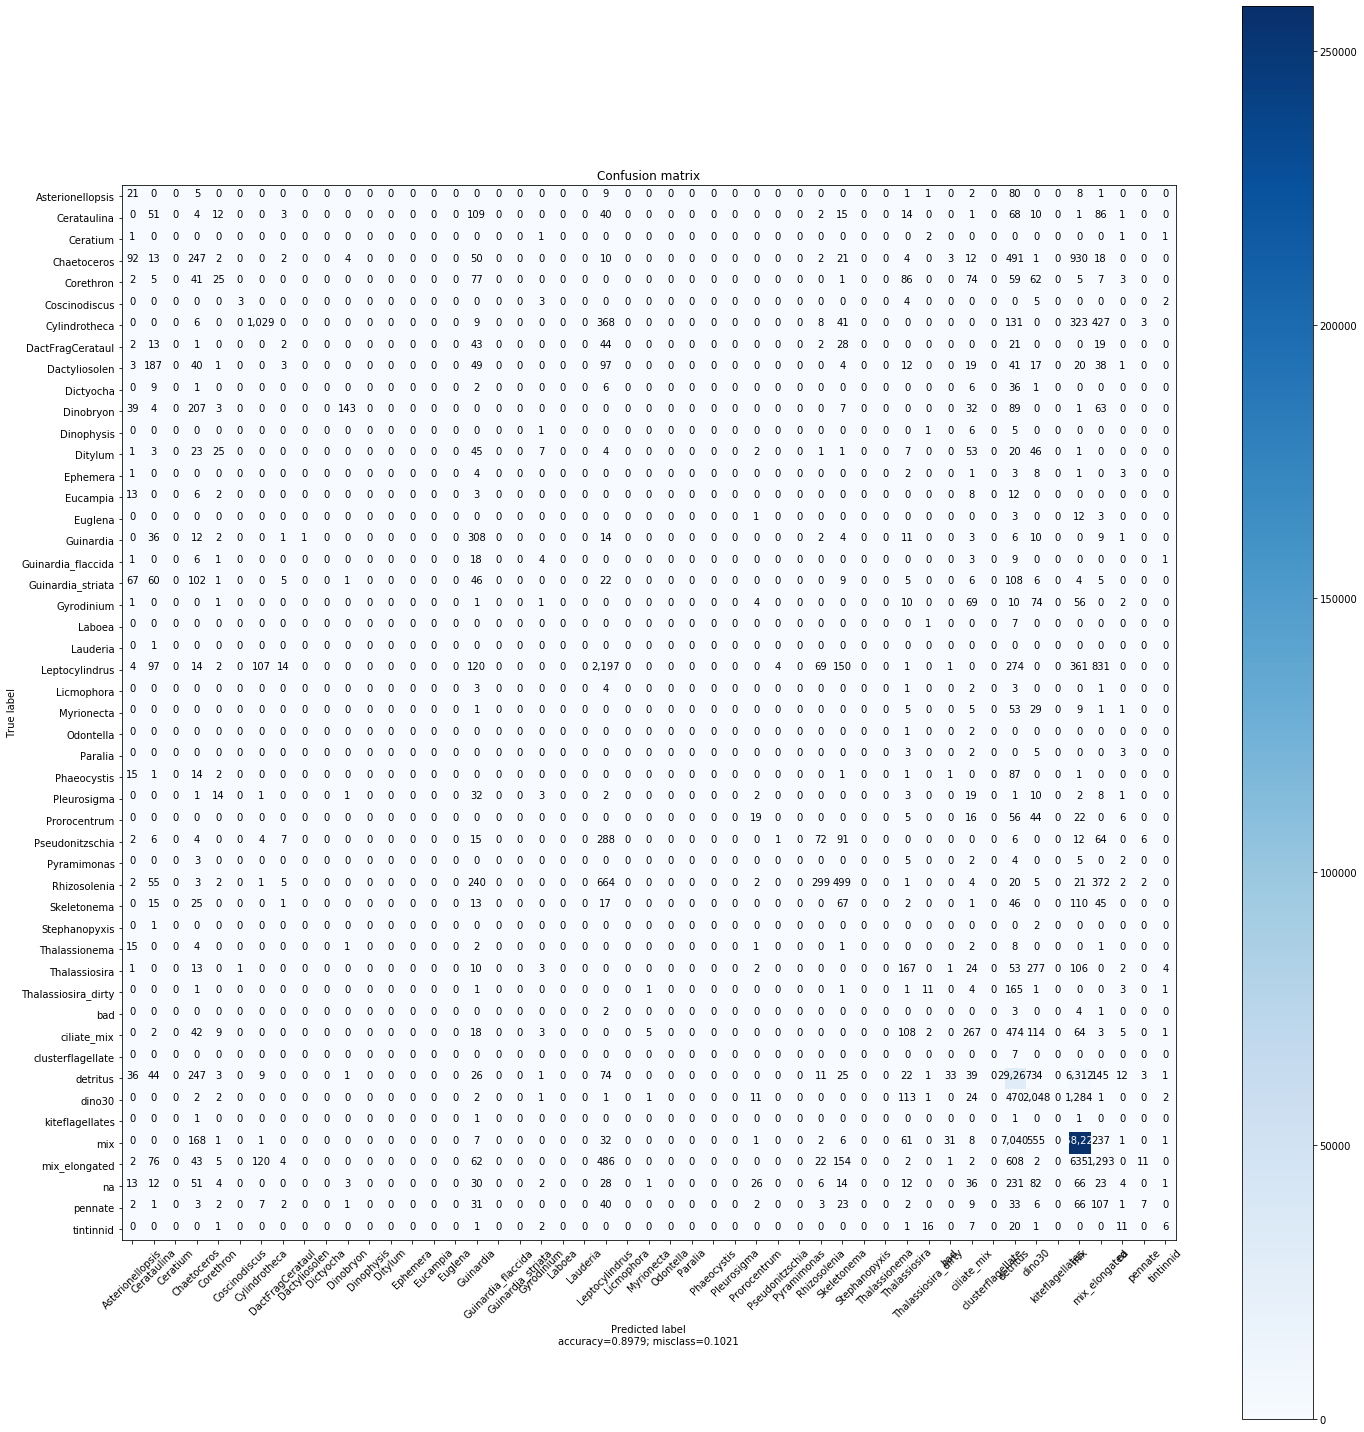

                     precision    recall  f1-score   support

   Asterionellopsis       0.06      0.16      0.09       128
        Cerataulina       0.07      0.12      0.09       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.18      0.13      0.15      1902
          Corethron       0.20      0.06      0.09       447
      Coscinodiscus       0.75      0.18      0.29        17
      Cylindrotheca       0.80      0.44      0.57      2345
   DactFragCerataul       0.04      0.01      0.02       175
      Dactyliosolen       0.00      0.00      0.00       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.92      0.24      0.38       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

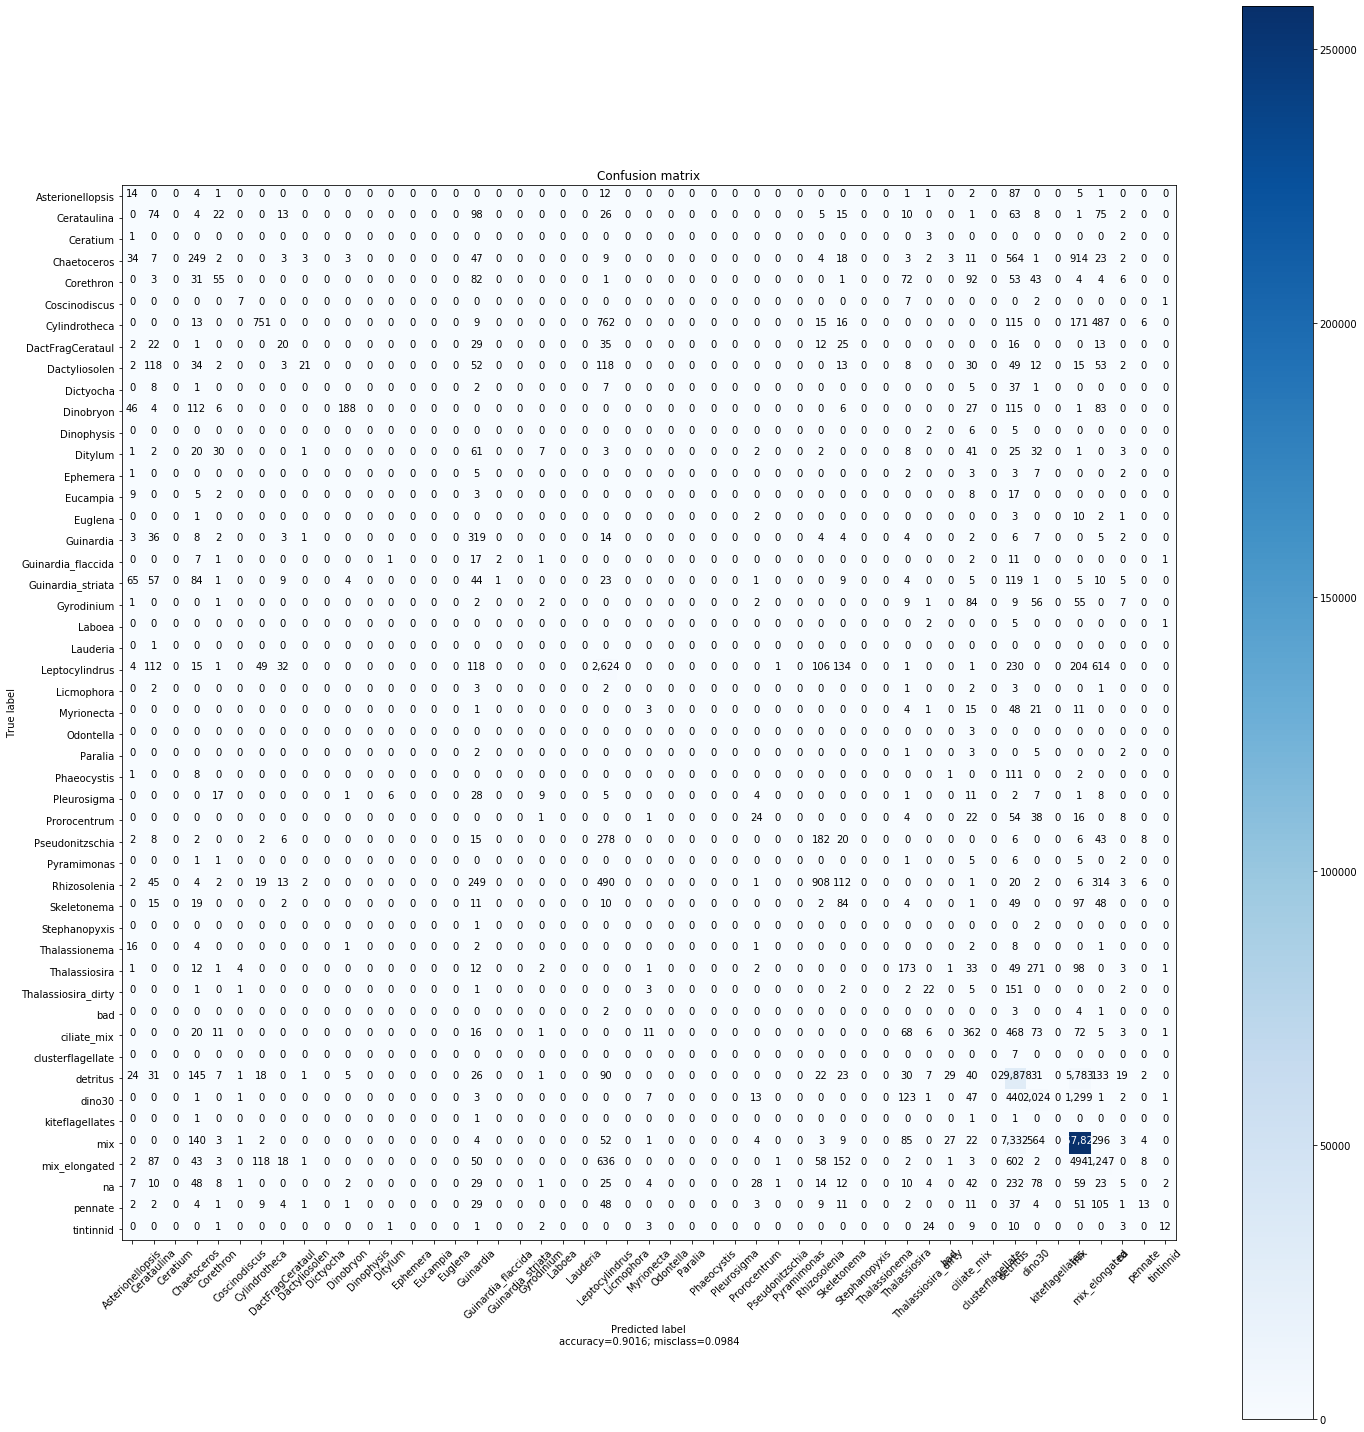

                     precision    recall  f1-score   support

   Asterionellopsis       0.06      0.11      0.08       128
        Cerataulina       0.11      0.18      0.14       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.24      0.13      0.17      1902
          Corethron       0.30      0.12      0.18       447
      Coscinodiscus       0.44      0.41      0.42        17
      Cylindrotheca       0.78      0.32      0.45      2345
   DactFragCerataul       0.16      0.11      0.13       175
      Dactyliosolen       0.68      0.04      0.07       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.92      0.32      0.47       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.00      0.00      0.00       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

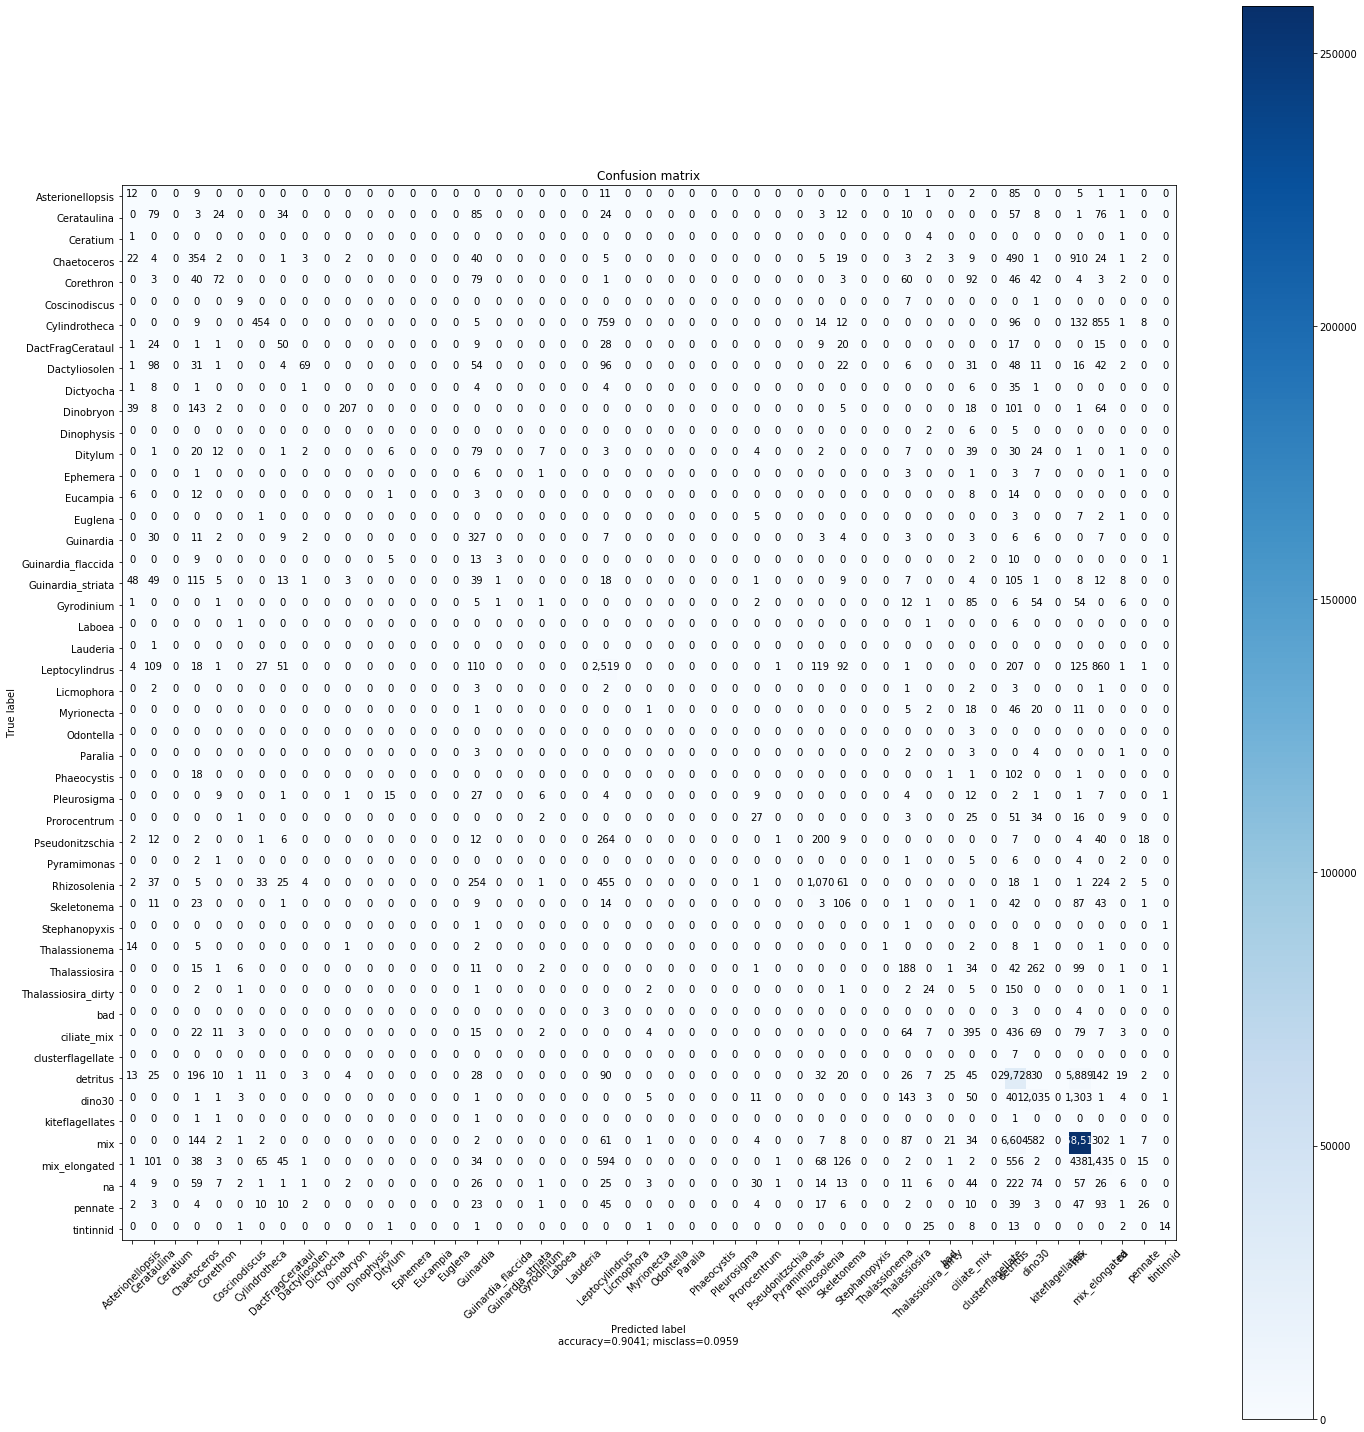

                     precision    recall  f1-score   support

   Asterionellopsis       0.07      0.09      0.08       128
        Cerataulina       0.13      0.19      0.15       417
           Ceratium       0.00      0.00      0.00         6
        Chaetoceros       0.27      0.19      0.22      1902
          Corethron       0.43      0.16      0.23       447
      Coscinodiscus       0.31      0.53      0.39        17
      Cylindrotheca       0.75      0.19      0.31      2345
   DactFragCerataul       0.20      0.29      0.23       175
      Dactyliosolen       0.78      0.13      0.22       532
          Dictyocha       0.00      0.00      0.00        61
          Dinobryon       0.94      0.35      0.51       588
         Dinophysis       0.00      0.00      0.00        13
            Ditylum       0.21      0.03      0.04       239
           Ephemera       0.00      0.00      0.00        23
           Eucampia       0.00      0.00      0.00        44
            Euglena    

In [22]:
from SimCLR.modules import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

for p in args.proportions:
    model = LogisticRegression(simclr_model.n_features, len(train_dataset.classes))
    model = model.to(args.device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    #optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()
    arr_train_loader = arr_train_loaders[p]
    print("Training dataset with proportion %f and %d labeled examples in training set"%(p,len(arr_train_loader)*args.logistic_batch_size))
    for epoch in range(args.logistic_epochs):
        loss_epoch, accuracy_epoch = train(args, arr_train_loader, model, criterion, optimizer)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch}/{args.logistic_epochs}]\t Loss: {loss_epoch / len(arr_train_loader)}\t Accuracy: {accuracy_epoch / len(arr_train_loader)}")

    # final testing
    y_true,y_pred = make_preds(args,model,arr_test_loader)
    #Build the confusion matrix here
    cm=confusion_matrix(y_true, y_pred)
    #Esto no está bien. habra que ver como sacar los nombres de las labesl que existan en el train(subset) y test
    labelswithexamples=np.union1d(np.unique(test_dataset.targets),np.unique(train_dataset.targets))
    labelswithexamples_names = np.array(list(test_dataset.class_to_idx.keys()))[labelswithexamples]
    plot_confusion_matrix(cm=cm,target_names=labelswithexamples_names,normalize=False)
    print(classification_report(y_true, y_pred,target_names=labelswithexamples_names))